In [1]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import srt
import torchaudio
from sklearn.model_selection import train_test_split
from torchaudio.transforms import Resample
from tqdm.notebook import tqdm

from data_analysis_common_utils import summarize_duration, summarize_sentences
from src.text.cleaners import remove_stress_marks

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
target_sr = 16000
studio_data_dir = Path(r"C:\Users\robert\Desktop\datasets\aurimas_studio_data")
srt_dir = studio_data_dir / "srts"
wav_dir = studio_data_dir / "wavs"
output_clips_dir = Path("../files/studio_clips")
output_clips_dir.mkdir(exist_ok=True, parents=True)

In [3]:
rows = []

# Process each SRT file
for srt_file in tqdm(list(srt_dir.glob("*.srt"))):
    base_name = srt_file.stem
    wav_file = wav_dir / f"{base_name}.wav"

    if not wav_file.exists():
        print(f"Skipping {base_name}, WAV not found.")
        continue

    with open(srt_file, "r", encoding="utf-8") as f:
        subs = list(srt.parse(f.read()))

    waveform, sr = torchaudio.load(wav_file)

    # Resample if needed
    if sr != target_sr:
        resampler = Resample(orig_freq=sr, new_freq=target_sr)
        waveform = resampler(waveform)
        sr = target_sr

    # Process each subtitle
    for idx, sub in enumerate(subs, start=1):
        start_sample = int(sub.start.total_seconds() * sr)
        end_sample = int(sub.end.total_seconds() * sr)

        clip_audio = waveform[:, start_sample:end_sample]
        clip_filename = f"{base_name}_{idx:04d}.wav"
        clip_path = output_clips_dir / clip_filename
        torchaudio.save(clip_path.as_posix(), clip_audio, sr)
        duration = clip_audio.shape[1] / sr

        # Collect row
        rows.append({
            "path": str(clip_path.relative_to("..")),
            "sentence": remove_stress_marks(sub.content.strip()),
            "duration[s]": duration
        })

df = pd.DataFrame(rows)
print(df.info())
df.head()

  0%|          | 0/12 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5294 entries, 0 to 5293
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   path         5294 non-null   object 
 1   sentence     5294 non-null   object 
 2   duration[s]  5294 non-null   float64
dtypes: float64(1), object(2)
memory usage: 124.2+ KB
None


,path,sentence,duration[s]
0,files\studio_clips\01-SKYRIUS_0001.wav,Pirmas skyrius.,0.766
1,files\studio_clips\01-SKYRIUS_0002.wav,Mes stovime devyni kilometrai nuo fronto.,2.198
2,files\studio_clips\01-SKYRIUS_0003.wav,Vakar mus pakeitė.,1.105
3,files\studio_clips\01-SKYRIUS_0004.wav,Mūsų pilvai net braška nuo pupelių su jautiena...,5.960
4,files\studio_clips\01-SKYRIUS_0005.wav,Net ir vakarienei kiekvienas galėjo pasiimti p...,9.986


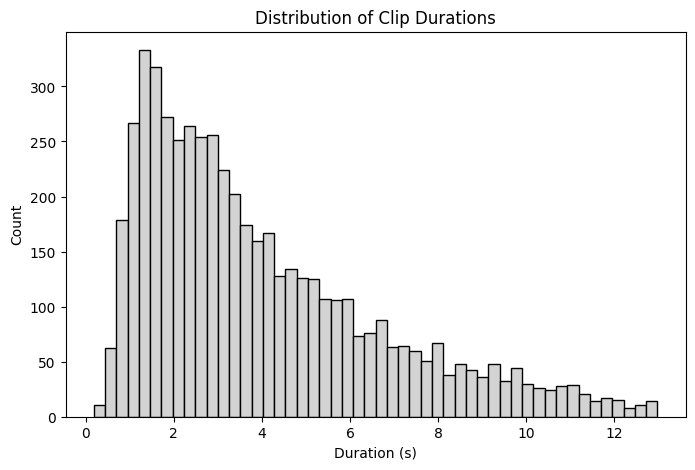

Summary statistics for duration[s]:
count    5294.000000
mean        3.993496
std         2.723045
min         0.182000
5%          0.962000
25%         1.854250
50%         3.208500
75%         5.451500
95%         9.713000
max        12.985000
Name: duration[s], dtype: float64


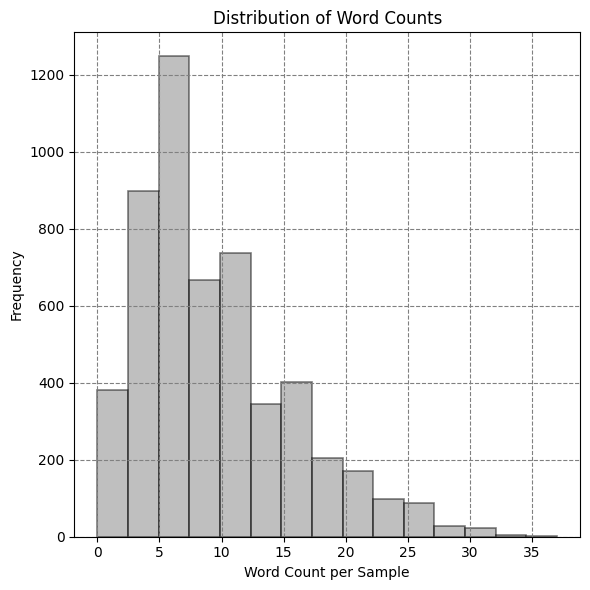


    Word statistics (Per Text):
        Total:       49583
        Unique:      13194
        Mean:         9.37
        STD:          6.18
        Median:       8.00
        Min:             0
        Max:            37
    


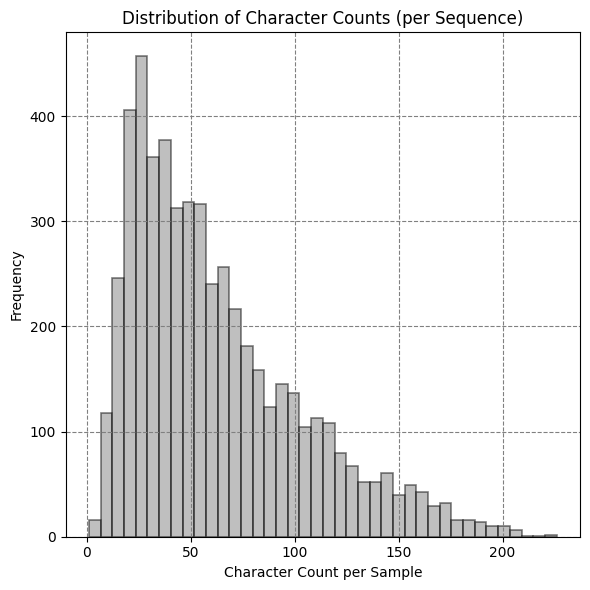


    Character statistics (Per Text):
        Total:      331484
        Mean:        62.62
        STD:         41.13
        Median:      52.00
        Min:             1
        Max:           226
    


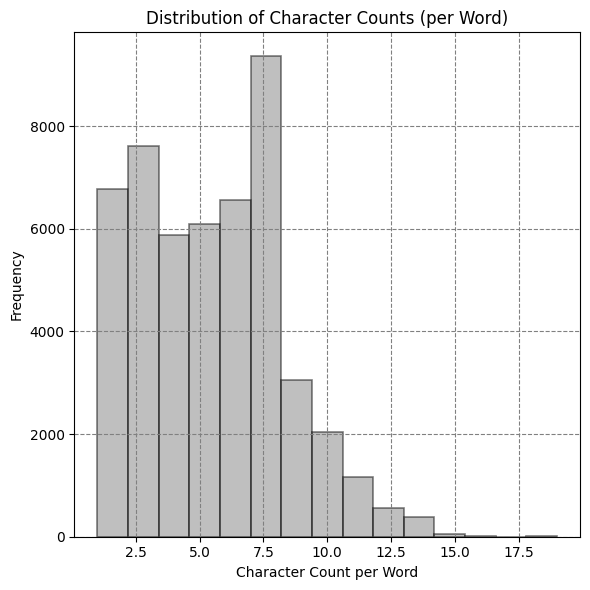


    Character statistics (Per Word):
        Total:      272668
        Mean:         5.50
        STD:          2.71
        Median:       5.00
        Min:             1
        Max:            19
    


In [4]:
# FULL DATASET
summarize_duration(df)
summarize_sentences(df)

In [5]:
train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    shuffle=True
)

print("Train size:", len(train_df))
print("Test size:", len(test_df))

Train size: 4764
Test size: 530


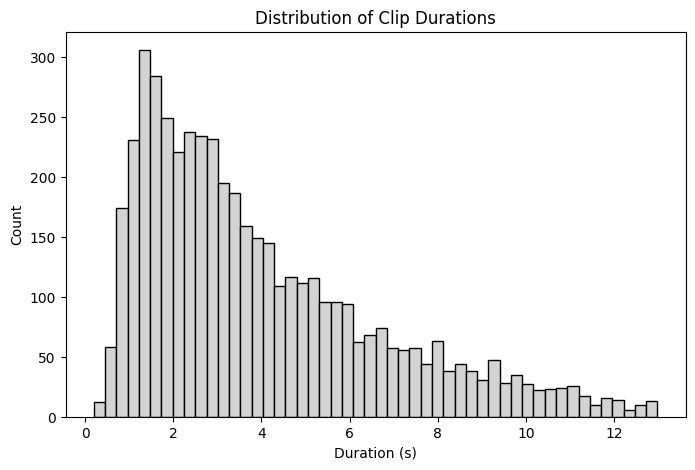

Summary statistics for duration[s]:
count    4764.000000
mean        3.982757
std         2.713095
min         0.199000
5%          0.962000
25%         1.853750
50%         3.202000
75%         5.430500
95%         9.681700
max        12.985000
Name: duration[s], dtype: float64


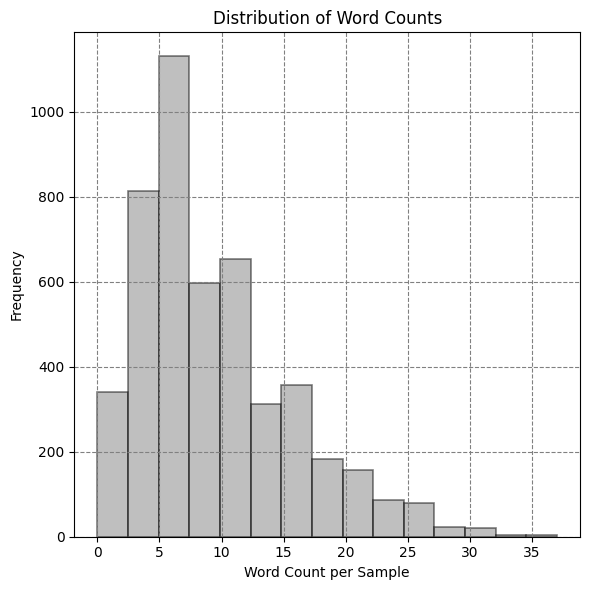


    Word statistics (Per Text):
        Total:       44557
        Unique:      12251
        Mean:         9.35
        STD:          6.18
        Median:       8.00
        Min:             0
        Max:            37
    


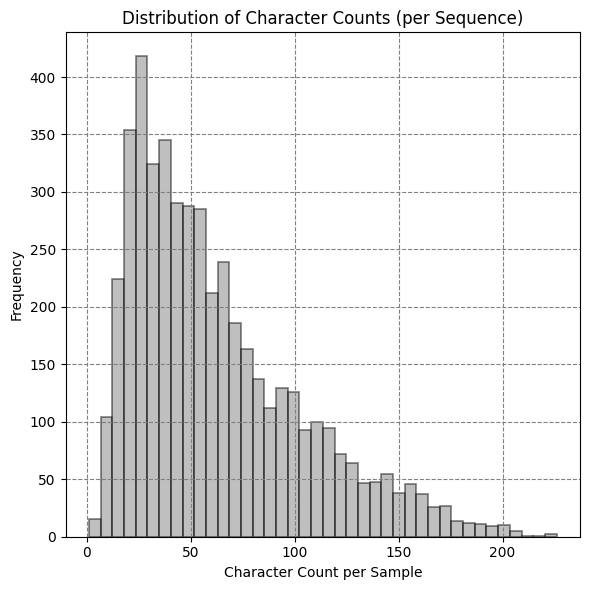


    Character statistics (Per Text):
        Total:      297810
        Mean:        62.51
        STD:         41.02
        Median:      52.00
        Min:             1
        Max:           226
    


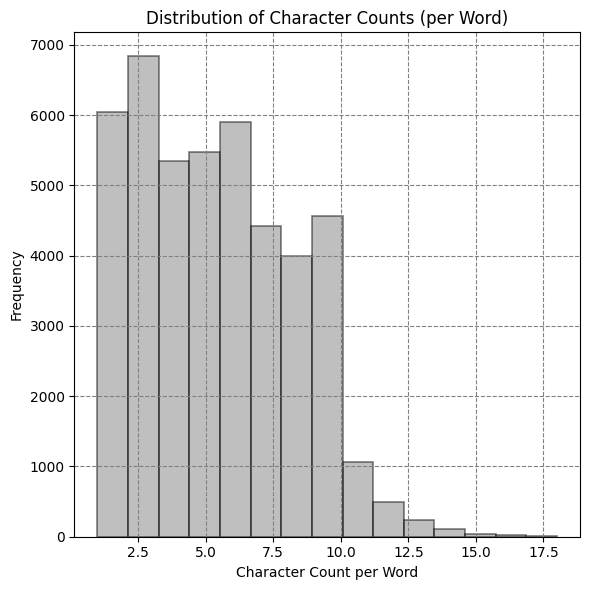


    Character statistics (Per Word):
        Total:      244987
        Mean:         5.50
        STD:          2.70
        Median:       5.00
        Min:             1
        Max:            18
    


In [6]:
# TRAINING SET
summarize_duration(train_df)
summarize_sentences(train_df)

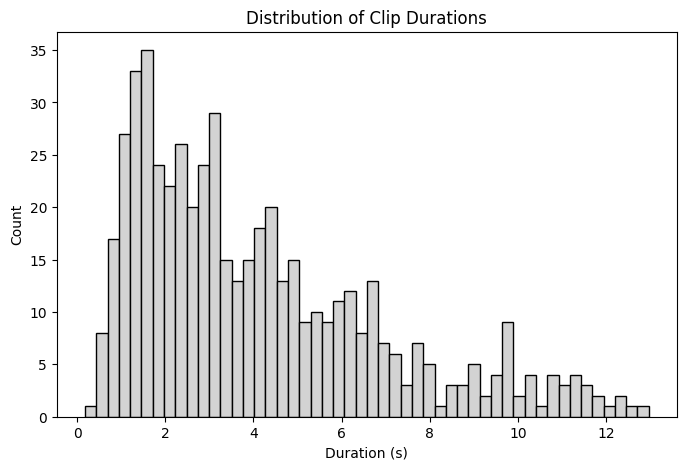

Summary statistics for duration[s]:
count    530.000000
mean       4.090026
std        2.811696
min        0.182000
5%         0.986850
25%        1.873250
50%        3.243500
75%        5.638750
95%       10.026900
max       12.961000
Name: duration[s], dtype: float64


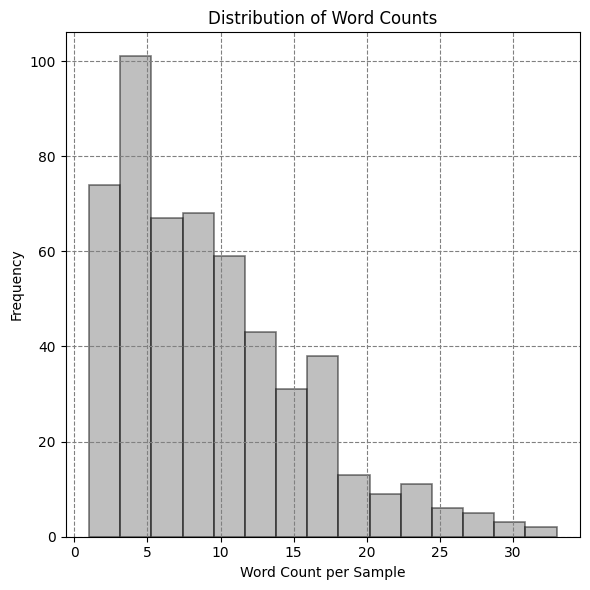


    Word statistics (Per Text):
        Total:        5026
        Unique:       2532
        Mean:         9.48
        STD:          6.24
        Median:       8.00
        Min:             1
        Max:            33
    


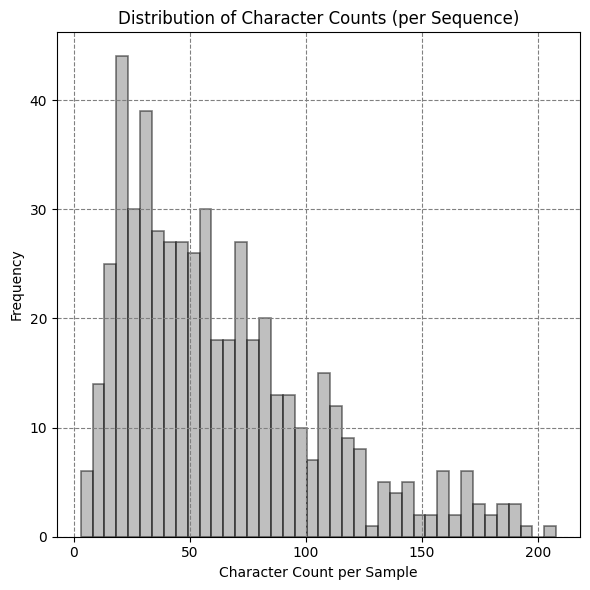


    Character statistics (Per Text):
        Total:       33674
        Mean:        63.54
        STD:         42.11
        Median:      54.00
        Min:             3
        Max:           208
    


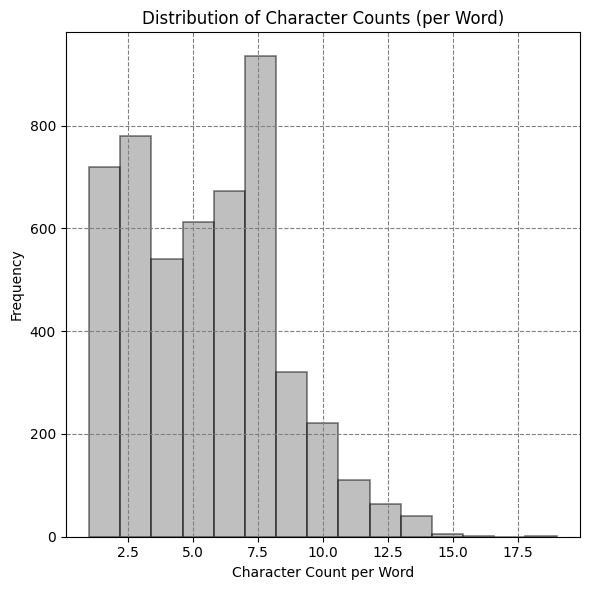


    Character statistics (Per Word):
        Total:       27681
        Mean:         5.51
        STD:          2.75
        Median:       5.00
        Min:             1
        Max:            19
    


In [7]:
# TESTING SET
summarize_duration(test_df)
summarize_sentences(test_df)

In [8]:
def save_filelist(_df: pd.DataFrame, out_path: str):
    df.to_csv(
        out_path,
        sep="|",
        index=False,
        header=False,
        columns=["path", "sentence"]
    )
    print(f"Saved filelist to {out_path}")


save_filelist(train_df, "../files/studio_train.txt")
save_filelist(test_df, "../files/studio_test.txt")

Saved filelist to ../files/studio_train.txt
Saved filelist to ../files/studio_test.txt
